<a href="https://colab.research.google.com/github/ENRICOBIGNOZZI1998/Simulate-performance-of-your-trading-system/blob/main/BTC_MOTOR_VOLUME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas==1.1.5 numpy==1.19.4 scipy==1.5.4
!pip3 install alpaca-trade-api
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.5 MB 1.0 MB/s 
     |████████████████████████████████| 14.5 MB 11.8 MB/s 
     |████████████████████████████████| 25.9 MB 1.5 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.4 which is incompatible.
tensorfl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 299 kB 6.8 MB/s 
     |████████████████████████████████| 106 kB 58.0 MB/s 
     |████████████████████████████████| 1.1 MB 65.0 MB/s 
     |████████████████████████████████| 55 kB 3.1 MB/s 
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.0.4
    Uninstalling msgpack-1.0.4:
      Successfully uninstalled msgpack-1.0.4
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.8.3
    Uninstalling aiohttp-3.8.3:
      Successfully uninstalled aiohttp-3.8.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime 
import json
import yfinance as yf
import alpaca_trade_api as api
from alpaca_trade_api.stream import Stream
from alpaca_trade_api.rest import REST, TimeFrame
API_SECRET =  "ViSACWJ0Pp38dUK5W9jUjhLhxVMfL3DYkqfcQg0g"
API_KEY = "PKQQTVU7RKTVLAMEIGMI"
base_url = "https://paper-api.alpaca.markets"
data_feed = "iex" # Change to "sip" if using paid subscription
# Instantiate Stream class
stream = Stream(API_KEY,
                API_SECRET,
                base_url=base_url,
                data_feed=data_feed,                 
                crypto_exchanges=['CBSE'],                
               )

In [3]:
def crossover(arr1,arr2):
    return(arr1>arr2)&(arr1.shift(1)<arr2.shift(1))
def crossunder(arr1,arr2):
    return(arr1<arr2)&(arr1.shift(1)>arr2.shift(1))
def drawdown(equity):#valore equity - valore max
    maxvalue=equity.expanding(0).max()
    drawdown=equity-maxvalue
    drawdown_series=pd.Series(drawdown, index=equity.index)
    return drawdown_series
def operation_number(operations):
    return operations.count()
def max_gain(operations):
    return round(operations.max(),2)
def max_drawdown_nozero(equity):
    dd=drawdown(equity)
    return round(dd[dd<0].min(),2)
def avgdrawdown_nozero(equity):#sofferenza media del sistema
    dd=drawdown(equity)
    return round(dd[dd<0].mean(),2)
def avg_delay_between_peaks(equity):#ritardo nel compiere massimi
    work_df=pd.DataFrame(equity,index=equity.index)
    work_df['drawdown']=drawdown(equity)
    work_df['delay_elements']=work_df['drawdown'].apply(lambda x:1 if x<0 else 0)
    work_df['resets']=np.where(work_df['drawdown']==0,1,0)
    work_df['cumsum']=work_df['resets'].cumsum()
    work_df.dropna(inplace=True)
    a=pd.Series(work_df['delay_elements'].groupby(work_df['cumsum']).sum())
    return round(a.mean(),2)
def delay_between_peaks(equity):#ritardo nel compiere massimi
    work_df=pd.DataFrame(equity,index=equity.index)
    work_df['drawdown']=drawdown(equity)
    work_df['delay_elements']=work_df['drawdown'].apply(lambda x:1 if x<0 else 0)
    work_df['resets']=np.where(work_df['drawdown']==0,1,0)
    work_df['cumsum']=work_df['resets'].cumsum()
    a=pd.Series(work_df['delay_elements'].groupby(work_df['cumsum']).cumsum())
    return a
def max_delay_between_peaks(equity):#quanto bisogna aspettare per vedere nuovi massimi
    a=delay_between_peaks(equity)
    return a.max()
def reward_risk_ratio(operations):
    if operations[operations<=0].mean()!=0:
        return round((operations[operations>0].mean()/-operations[operations<=0].mean()),2)
    else:
        return np.inf
def percent_win(operations):
    return round((operations[operations>0].count()/operations.count()*100),2)
def profit_factor(operations):
    a=gross_profit(operations)
    b=gross_loss(operations)
    if b!=0:
        return round(abs(a/b),2)
    else:
        return round(abs(a/0.000000001),2)
def gross_profit(operations):
    return round(operations[operations>0].sum(),2)
def gross_loss(operations):
    return round(operations[operations<0].sum(),2)
def avg_loss(operations):
    return round(operations[operations<0].mean(),2)
def max_loss(operations):
    return round(operations.min(),2)
def max_loss_date(operations):
    return operations.idxmin()
def max_win(operations):
    return round(operations.max(),2)
def max_win_date(operations):
    return operations.idxmax()
def avg_gain(operations):
    return round(operations[operations>0].mean(),2)
def avg_trade(operations):
    return round(operations.mean(),2)
def max_draw_down(equity):
    dd=drawdown(equity)
    return round(dd.min(),2)
def avgdown_nozero(equity):#sofferenza media del sistema
    dd=drawdown(equity)
    return round(dd[dd<0].mean(),2)
def profit(equity):
    return round(equity[-1],2)

In [4]:
def plot_drawdown(equity,color):
    dd=drawdown(equity)
    plt.figure(figsize=(14,8),dpi=100)
    plt.plot(dd,color=color)
    plt.fill_between(dd.index,0,dd,color=color)
    plt.xlabel="time"
    plt.ylabel="profit/Loss"
    plt.title('Draw Down')
    plt.show()
    return
def plot_equity(equity,color):
    plt.figure(figsize=(14,8),dpi=100)
    plt.plot(equity,color=color)
    plt.xlabel="time"
    plt.ylabel="profit/Loss"
    plt.title('equity line')
    plt.show()
    return
def plot_equity_heatmap(operations,annotations):
    monthly=operations.resample('M').sum()
    toHeatMap=pd.DataFrame(monthly)
    toHeatMap['Year']=toHeatMap.index.year
    toHeatMap['Month']=toHeatMap.index.month
    show=toHeatMap.groupby(by=['Year','Month']).sum().unstack()
    show.columns=['gennaio','febbraio','marzo','aprile','maggio','giugno','luglio','agosto','settembre','ottobre','novembre','dicembre']
    plt.figure(figsize=(10,7),dpi=120)
    sns.heatmap(show,cmap="RdYlGn",linecolor="white",linewidth=0.1,annot=annotations,vmin=-max(monthly.min(),monthly.max()),vmax=monthly.max())
    return
def plot_monthly_bias_histogram(operations):
    monthly=pd.DataFrame(operations.fillna(0)).resample('M').sum()
    monthly['Month']=monthly.index.month
    biasMonthly=[]
    months=[]
    for month in range(1,13):
        months.append(month)
    for month in months:
        biasMonthly.append(monthly[(monthly['Month']==month)].mean())
    biasMonthly=pd.DataFrame(biasMonthly)
    column=biasMonthly.columns[0]
    colors=pd.Series()
    colors=biasMonthly[column].apply(lambda x:'green' if x>0 else 'red')
    n_groups=len(biasMonthly)
    plt.subplots(figsize=(10,7),dpi=100)
    index=np.arange(n_groups)
    bar_width=0.35
    opacity=1
    rectls1=plt.bar(index,biasMonthly[column],bar_width,alpha=opacity,color=colors,label='yearly statistics')
    #plt.xlabel('years')
    #plt.ylabel('profit-loss')
    months_names=['gennaio','febbraio','marzo','aprile','mggio','giugno','luglio','agosto','settembre','ottobre','novembre','dicembre']
    plt.xticks(index,months_names,rotation=45)
    plt.grid(True)
    plt.show()
    return
def plot_annual_histogram(operations):
    yearly=operations.resample('A').sum()
    colors=pd.Series()
    colors=yearly.apply(lambda x:'green' if x>0 else 'red')
    n_groups=len(yearly)
    plt.subplots(figsize=(10,7),dpi=100)
    index=np.arange(n_groups)
    bar_width=0.35
    opacity=1
    rectls1=plt.bar(index,yearly,bar_width,alpha=opacity,color=colors,label='yearly statistics')

    #plt.xlabel('years')
    #plt.ylabel('profit-loss')
    plt.xticks(index,yearly.index.year,rotation=90)
    plt.grid(True)
    plt.show()
    return

In [5]:
def performance_report(trading_system,operations,closed_equity,open_equity):
    print("Performance report")
    print("")
    print("profit:                ",profit(open_equity))
    print("operations:            ",operation_number(operations))
    print("avarage Trade:         ",avg_trade(operations))
    print("")
    print("profit factor:         ",profit_factor(operations))
    print("gross profit:          ",gross_profit(operations))
    print("percent winning trade: ",percent_win(operations))
    print("reward risk ratio:     ",reward_risk_ratio(operations))
    print("")
    print("max gain:              ",max_gain(operations))
    print("avarage gain:          ",avg_gain(operations))
    print("max loss:              ",max_loss(operations))
    print("avarage loss:          ",avg_loss(operations))
    print("")
    print("avg open draw down:    ",avgdrawdown_nozero(open_equity))
    print("max open draw down:    ",max_drawdown_nozero(open_equity))
    print("")
    print("avg closed draw down:   ",avgdrawdown_nozero(trading_system.closed_equity))
    print("max closed draw down:   ",max_drawdown_nozero(trading_system.closed_equity))
    print("")
    print("avg delay between peaks:",avgdrawdown_nozero(trading_system.closed_equity))
    print("max delay between peaks:",max_drawdown_nozero(trading_system.closed_equity))
    plot_equity(trading_system.open_equity,"green")
    plot_drawdown(trading_system.open_equity,"red")
    plot_annual_histogram(operations)
    plot_monthly_bias_histogram(operations)
    plot_equity_heatmap(operations,False)
    return

In [6]:
def marketposition_generator(enter_rules,exit_rules):
    service_df=pd.DataFrame(index=enter_rules.index)
    service_df['enter_rules']=enter_rules
    service_df['exit_rules']=exit_rules
    status=0
    mp=[]
    for (i,j) in zip(enter_rules,exit_rules):#lega enter e exit con il loro valore temporale
        if status==0:
            if i ==1 and j!=-1:
                status=1
        else:
            if j==-1:
                status=0
        mp.append(status)
    service_df['mp_new']=mp
    service_df.mp_new=service_df.mp_new.shift(1)#ritardo mp
    service_df.iloc[0,2]=0
    #service_df.to_csv("marketposition_generator.csv")
    return service_df.mp_new

import math

def tick_correction_up(level,tick):
    if level != level:
        level=0
    multiplier=math.ceil(level/tick)
    return multiplier*tick

def tick_correction_down(level,tick):
    if level != level:
        level=0
    multiplier=math.floor(level/tick)
    return multiplier*tick

def stop_check(dataframe,rules,level,direction):
    service_dataframe=pd.DataFrame(index=dataframe.index)
    service_dataframe['rules']=rules
    service_dataframe['level']=level #livelli di ingresso boolenani
    service_dataframe['low']=dataframe.Low
    service_dataframe['high']=dataframe.High
    if direction=='long':
        service_dataframe['new_rules']=np.where((service_dataframe.rules==True)&(service_dataframe.high.shift(-1)>= service_dataframe.level.shift(-1)),True,False)
    if direction=='short':
        service_dataframe['new_rules']=np.where((service_dataframe.rules==True)&(service_dataframe.low.shift(-1)<= service_dataframe.level.shift(-1)),True,False)
    return service_dataframe.new_rules

def limit_check(dataframe,rules,level,direction):
    service_dataframe=pd.DataFrame()
    service_dataframe['rules']=rules
    service_dataframe['level']=level
    service_dataframe['low']=dataframe.Low
    service_dataframe['high']=dataframe.High
    if direction=='long':
        service_dataframe['new_rules']=np.where((service_dataframe.rules==True)&(service_dataframe.low.shift(-1)<=  service_dataframe.level.shift(-1)),True,False)
    if direction=='short':
        service_dataframe['new_rules']=np.where((service_dataframe.rules==True)&(service_dataframe.high.shift(-1)>=  service_dataframe.level.shift(-1)),True,False)
    return service_dataframe.new_rules

In [7]:
def apply_trading_system(imported_dataframe,bigpoint_value,tick,direction,order_type,enter_level, enter_rules,exit_rules):
    dataframe=imported_dataframe.copy()
    if order_type=="stop":
        enter_rules=stop_check(dataframe,enter_rules,enter_level,direction)
    if order_type=="limit":
        enter_rules=limit_check(dataframe,enter_rules,enter_level,direction)
    dataframe['enter_level']=enter_level
    dataframe['enter_rules']=enter_rules.apply(lambda x: 1 if x==True else 0)
    dataframe['exit_rules']=exit_rules.apply(lambda x: -1 if x==True else 0)
    dataframe['mp']=marketposition_generator(dataframe.enter_rules,dataframe.exit_rules)
    if order_type=="market":
        dataframe['entry_price']=np.where((dataframe.mp.shift(1)==0)&(dataframe.mp==1),dataframe.Open, np.nan)
        if instruments==1:
            dataframe['number_of_stocks']=np.where((dataframe.mp.shift(1)==0)&(dataframe.mp==1),operation_money/dataframe.Open,np.nan)
    if order_type=="stop":
        if direction=="long":
            dataframe.enter_level=dataframe.enter_level.apply(lambda x: tick_correction_up(x,tick))
            real_entry=np.where(dataframe.Open>dataframe.enter_level,dataframe.Open,dataframe.enter_level)
            dataframe['entry_price']=np.where((dataframe.mp.shift(1)==0)&(dataframe.mp==1),real_entry,np.nan)
        if direction=="short":
            dataframe.enter_level=dataframe.enter_level.apply(lambda x: tick_correction_down(x,tick))
            real_entry=np.where(dataframe.Open<dataframe.enter_level,dataframe.Open,dataframe.enter_level)
            dataframe['entry_price']=np.where((dataframe.mp.shift(1)==0)&(dataframe.mp==1),real_entry,np.nan)
        if instruments==1:
            dataframe['number_of_stocks']=np.where((dataframe.mp.shift(1)==0)&(dataframe.mp==1),operation_money/real_entry,np.nan)
   
    if order_type=="limit":
        if direction=="long":
            dataframe.enter_level=dataframe.enter_level.apply(lambda x: tick_correction_down(x,tick))
            real_entry=np.where(dataframe.Open<dataframe.enter_level,dataframe.Open,dataframe.enter_level)
            dataframe['entry_price']=np.where((dataframe.mp.shift(1)==0)&(dataframe.mp==1),real_entry,np.nan)
        if direction=="short":
            dataframe.enter_level=dataframe.enter_level.apply(lambda x: tick_correction_up(x,tick))
            real_entry=np.where(dataframe.Open>dataframe.enter_level,dataframe.Open,dataframe.enter_level)
            dataframe['entry_price']=np.where((dataframe.mp.shift(1)==0)&(dataframe.mp==1),real_entry,np.nan)
        if instruments==1:
            dataframe['number_of_stocks']=np.where((dataframe.mp.shift(1)==0)&(dataframe.mp==1),operation_money/real_entry,np.nan)
    dataframe['entry_price']=dataframe['entry_price'].fillna(method='ffill')
    dataframe['events_in']=np.where((dataframe.mp==1)&(dataframe.mp.shift(1)==0),'entry','')
    if instruments==1:
        dataframe['number_of_stocks']=dataframe['number_of_stocks'].apply(lambda x: round(x,0)).fillna(method='ffill')
        
    if direction=="long":
        if instruments==1:
            dataframe['open_operations']=(dataframe.Close-dataframe.entry_price)*dataframe.number_of_stocks
            dataframe['open_operations']=np.where((dataframe.mp==1)&(dataframe.mp.shift(-1)==0),(dataframe.Open.shift(-1)-dataframe.entry_price)*dataframe.number_of_stocks-2*costs,dataframe.open_operations)
        if instruments==2:
            dataframe['open_operations']=(-dataframe.entry_price+dataframe.Close)*bigpoint_value
            dataframe['open_operations']=np.where((dataframe.mp==1)&(dataframe.mp.shift(-1)==0),(dataframe.Open.shift(-1)-dataframe.entry_price)*bigpoint_value-2*costs,dataframe.open_operations)
    if direction=="short":
        if instruments==1:
            dataframe['open_operations']=(dataframe.entry_price-dataframe.Close)*dataframe.number_of_stocks
            dataframe['open_operations']=np.where((dataframe.mp==1)&(dataframe.mp.shift(-1)==0),(-dataframe.Open.shift(-1)+dataframe.entry_price)*dataframe.number_of_stocks-2*costs,dataframe.open_operations)
        if instruments==2:
            dataframe['open_operations']=(dataframe.entry_price-dataframe.Close)*bigpoint_value
            dataframe['open_operations']=np.where((dataframe.mp==1)&(dataframe.mp.shift(-1)==0),(-dataframe.Open.shift(-1)+dataframe.entry_price)*bigpoint_value-2*costs,dataframe.open_operations)
    dataframe['open_operations']=np.where(dataframe.mp==1,dataframe.open_operations,0)
    print(dataframe.entry_price[10:])
    dataframe['events_out']=np.where((dataframe.mp==1)&(dataframe.exit_rules==-1),'exit','')
    dataframe['operations']=np.where((dataframe.exit_rules==-1)&(dataframe.mp==1),dataframe.open_operations,np.nan)
    dataframe['closed_equity']=dataframe.operations.fillna(0).cumsum()
    dataframe['open_equity']=dataframe.closed_equity+dataframe.open_operations-dataframe.operations.fillna(0)
    dataframe.to_csv('trading_system_export.csv')
    return dataframe

In [8]:
#ANALISI DI AUTOCORRELAZIONE E STOPLOSS

In [9]:
#analisi dei gap

In [10]:
#analisi dei lap

In [11]:
BASE_URL = "https://paper-api.alpaca.markets"
alpaca_client = api.REST(API_KEY, API_SECRET, BASE_URL)
symbol = "BTCUSD"
start = "2022-08-01"
end = datetime.date.today()
bars = alpaca_client.get_crypto_bars(symbol,TimeFrame.Minute,start, end).df
df=pd.DataFrame.from_dict(bars)
df = df[df.exchange == 'CBSE']#scelgo l'exchange
columns=["open", "high", "low", "close", "volume"]
df=df[columns]
df['Open']=df['open']
df['High']=df['high']
df['Low']=df['low']
df['Close']=df['close']
df['Volume']=df['volume']
columns1=["Open", "High", "Low", "Close", "Volume"]
df=df[columns1]

In [13]:
df['minute']=df.index.minute
df['day']=df.index.day
df['month']=df.index.month
df['year']=df.index.year
df['hour']=df.index.hour
df['minute']=df.index.minute
df['dayofyear']=df.index.dayofyear
df['dayofweek']=df.index.dayofweek
df['quarter']=df.index.quarter#quadrimestre in corso
df['hhv92']=df.High.rolling(92).max()
df['hhv23']=df.High.rolling(23).max()
df['hhv11']=df.High.rolling(11).max()
df['hhv59']=df.High.rolling(59).max()
df['llv92']=df.Low.rolling(92).min()
df['llv11']=df.Low.rolling(11).min()


df

,Open,High,Low,Close,Volume,minute,day,month,year,hour,...,dayofweek,quarter,hhv92,hhv23,hhv11,hhv59,llv92,llv11,apertura,chiusura
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-08-01 05:00:00+00:00,23401.89,23408.78,23395.06,23407.62,1.519613,0,1,8,2022,5,...,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23401.89
2022-08-01 05:01:00+00:00,23408.03,23411.76,23404.01,23411.64,0.444291,1,1,8,2022,5,...,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23408.03
2022-08-01 05:02:00+00:00,23410.76,23430.10,23408.54,23422.08,10.172835,2,1,8,2022,5,...,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23410.76
2022-08-01 05:03:00+00:00,23423.45,23425.00,23407.05,23409.35,2.797403,3,1,8,2022,5,...,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23423.45
2022-08-01 05:04:00+00:00,23406.35,23409.98,23402.74,23407.45,0.544651,4,1,8,2022,5,...,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23406.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-02 02:09:00+00:00,20467.08,20470.98,20462.11,20467.50,6.137344,9,2,11,2022,2,...,2,4,20536.81,20519.30,20509.20,20536.81,20458.41,20458.41,NaN,20467.08
2022-11-02 02:10:00+00:00,20468.12,20477.72,20466.66,20474.96,7.310011,10,2,11,2022,2,...,2,4,20536.81,20519.08,20508.28,20536.81,20458.41,20458.41,NaN,20468.12
2022-11-02 02:11:00+00:00,20473.65,20486.38,20472.86,20483.91,12.555028,11,2,11,2022,2,...,2,4,20536.81,20518.70,20501.91,20536.81,20458.41,20458.41,NaN,20473.65


timestamp
2022-08-01 09:10:00+00:00        NaN
2022-08-01 09:11:00+00:00        NaN
2022-08-01 09:12:00+00:00        NaN
2022-08-01 09:13:00+00:00        NaN
2022-08-01 09:14:00+00:00        NaN
                              ...   
2022-11-02 01:06:00+00:00    20547.7
2022-11-02 01:07:00+00:00    20547.7
2022-11-02 01:08:00+00:00    20547.7
2022-11-02 01:09:00+00:00    20547.7
2022-11-02 01:10:00+00:00    20547.7
Name: entry_price, Length: 133336, dtype: float64
Performance report

profit:                 856.7
operations:             186
avarage Trade:          4.61

profit factor:          1.02
gross profit:           40213.2
percent winning trade:  45.7
reward risk ratio:      1.21

max gain:               3545.3
avarage gain:           473.1
max loss:               -8270.1
avarage loss:           -393.57

avg open draw down:     -8840.12
max open draw down:     -16016.7

avg closed draw down:    -9241.15
max closed draw down:    -15815.3

avg delay between peaks: -9241.15
max delay

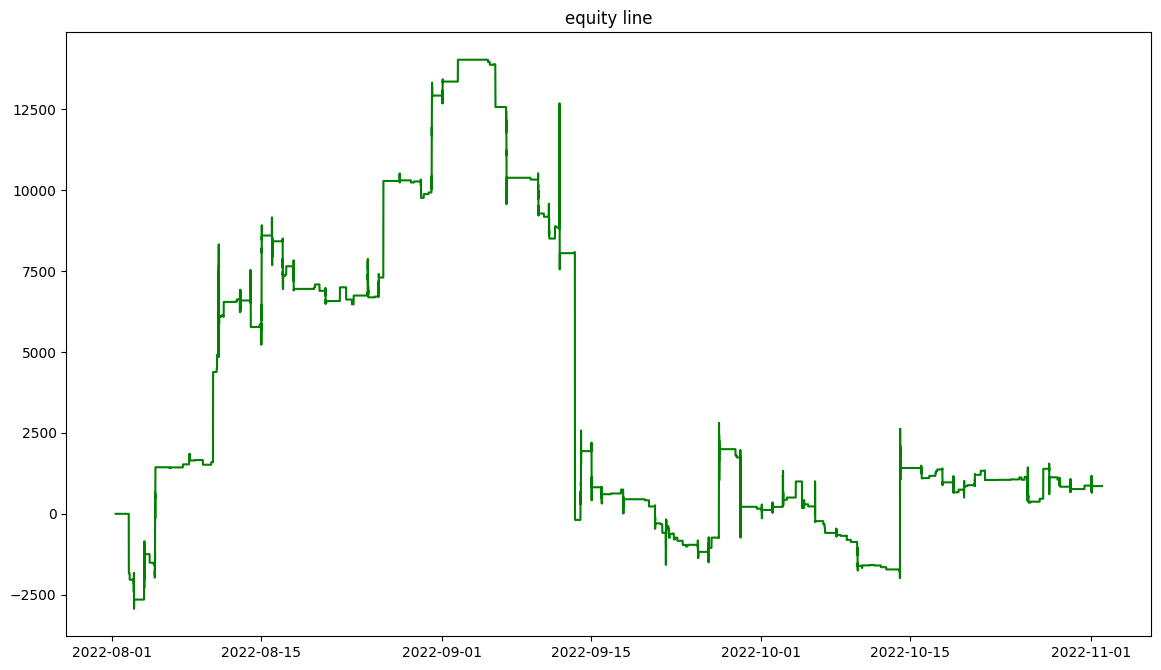

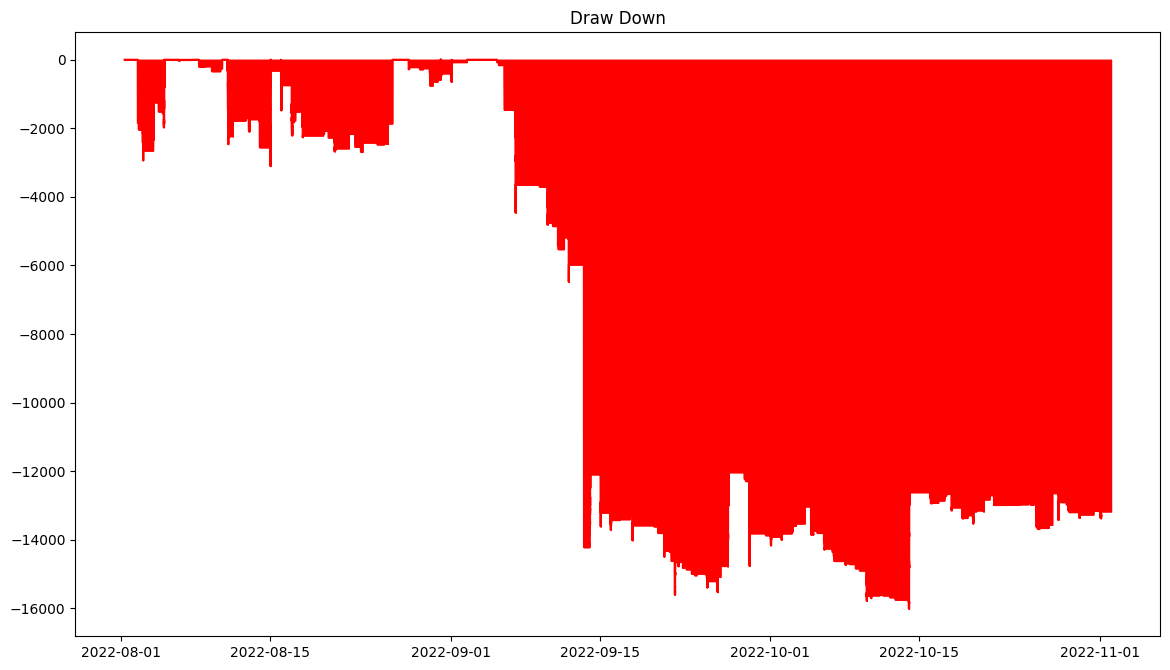

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


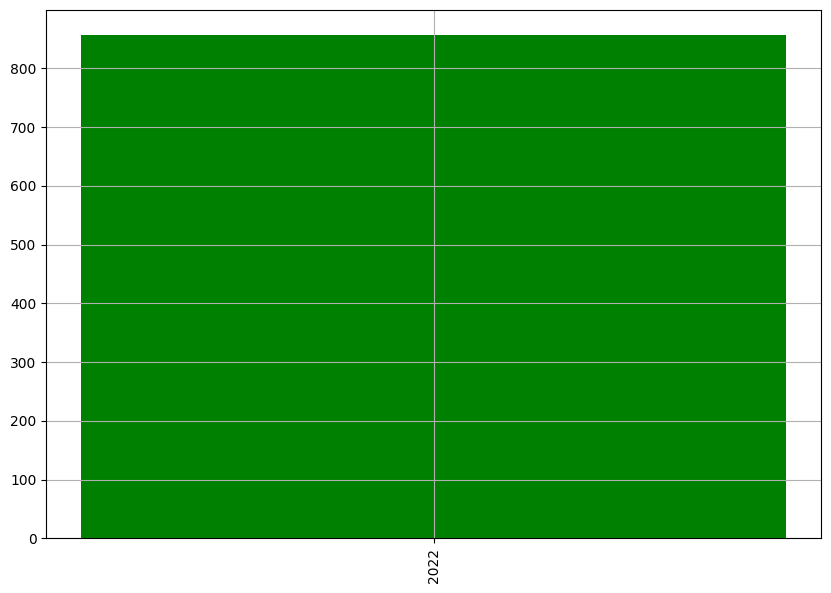

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


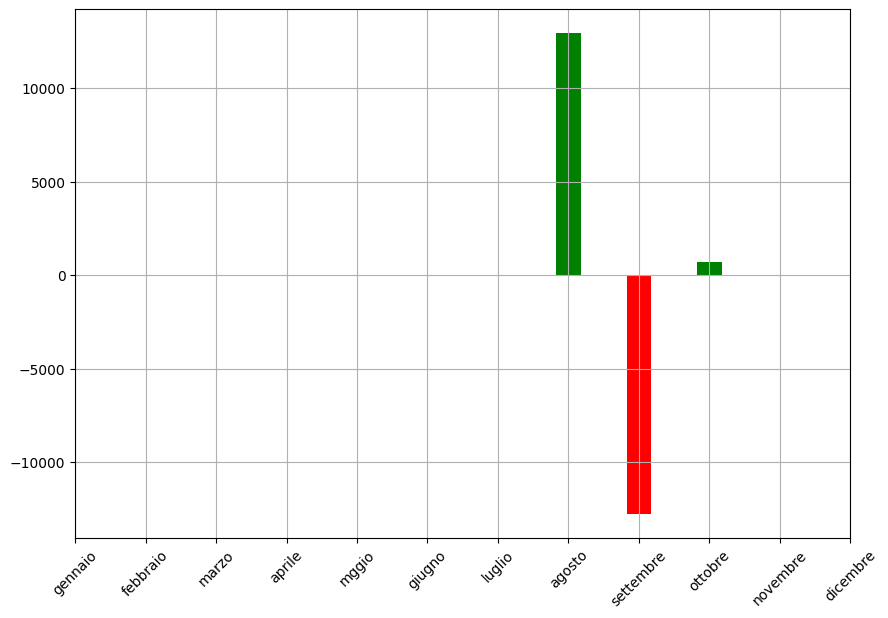

ValueError: ignored

In [14]:
bigpointvalue=10
df.dropna(inplace=True)
costs=0#costi fissi per trading
instruments=2 #1=azioni/valute, 2=future
operation_money=1000#investimento monetario
tick=0.1
direction="long"#oppure short
order_type="stop"#oppure limit o stop
#print(df)
#enter_rules=(df.hour==1)#|(df.hour>12)
#enter_level=df.hhv11.shift(1)#*60
#exit_rules= (df.hour==5)#|(df.hour==15)
enter_rules=(df.minute==29)|(df.hour==1)
enter_level=df.hhv59.shift(1)#*60
exit_rules= (df.minute==30)|(df.hour==5)
trading_system=apply_trading_system(df,bigpointvalue,tick,direction,order_type,enter_level,enter_rules,exit_rules)
#print(trading_system.mp)

operations=trading_system.operations.dropna()
if operations.count()>0:
    performance_report(trading_system,operations,trading_system.closed_equity,trading_system.open_equity)
else:
    print("Non ho fatto nessuna operazione capo!")